In [23]:
import requests
import json
import random
from collections import namedtuple
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mplfinance as mpf

pd.set_option('display.max_columns', None)

headers = {
    'Referer': 'http://quote.eastmoney.com/',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}
%matplotlib inline

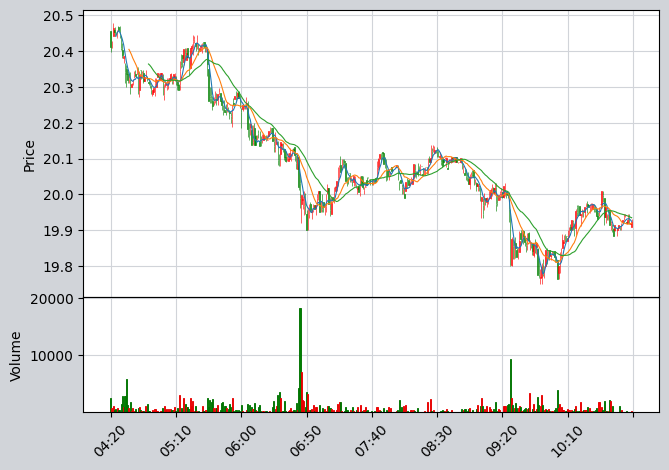

In [24]:
df = pd.read_csv('../material/binance-toy-data.csv', parse_dates=['time'])
df = df.set_index('time', drop=True)

df.index = pd.to_datetime(df.index)
df.index.name = 'Date'
my_color = mpf.make_marketcolors(up='r', down='g', edge='inherit', wick='inherit', volume='inherit')
# 设置图表的背景色
my_style = mpf.make_mpf_style(marketcolors=my_color, figcolor='(0.82, 0.83, 0.85)', gridcolor='(0.82, 0.83, 0.85)')

mpf.plot(df.iloc[-400:], style=my_style, mav=(5, 15, 30), type='candle', volume=True)

plt.show()

In [27]:
Deal = namedtuple("Deal", ["code", "date", "operation", "amount", "price", "fee", "total"])

class Account:
    
    def __init__(self, uid, unit=100, fee_rate=2.5e-4):
        self.uid = uid
        self._cash = 0

        # Hold Position
        self.holds = {}
        # List of deals
        self.deals = []
        # The minimum amount of one transaction
        self.unit = unit
        # Commission on a transaction, both buy and sell operation need commission.
        self.fee_rate = fee_rate
    
    def __repr__(self):
        s = f'{self.__class__.__name__}(cash={self.cash:.2f}, value={self.value:.2f}, profit={self.profit:.2f})'
        return s

    @property
    def cash(self):
        return self._cash

    @cash.setter
    def cash(self, value):
        assert isinstance(value, (int, float)) and value >= 0.0
        self._cash = value

    def withdraw(self, amount):
        assert isinstance(amount, (int, float)) and amount >= 0.0
        if self.cash >= amount:
            self.cash -= amount
            return True
        else:
            return False
    
    def deposit(self, amount):
        assert isinstance(amount, (int, float)) and amount >= 0.0
        self.cash += amount
        return True
    @property
    def holdings(self):
        return sum(item["amount"] for _, item in self.holds.items())
    @property
    def value(self):
        return sum(item["amount"] * item["price"] for _, item in self.holds.items())
    @property
    def cost(self):
        return sum(item["cost"] for _, item in self.holds.items())
    @property
    def captial(self):
        return self.cash + self.value
    @property
    def profit(self):
        return self.value - self.cost
    @property
    def balance(self):
        return self.cash + self.value - self.cost

    def assets(self):
        print(30*"=")
        print(f"{'Type':10s}|{'Amount':>8s}|{'Value':>10s}")
        print(30*"-")
        print(f"{'Cash':10s}|{'--':>8s}|{self.cash:10.2f}")
        for code, item in self.holds.items():
            print(f"{code:10s}|{item['amount']:8d}|{item['amount']*item['price']:10.2f}")
        print(30*"=")

    def transactions(self):
        print(76*"=")
        print(f"{'Date':20s}|{'Op':>6s}|{'Symbol':>10s}|{'Amount':>10s}|{'Price':>8s}|{'Fee':>8s}|{'Total':>8s}")
        print(76*"-")
        for deal in self.deals:
            print(f"{deal.date:20s}|{deal.operation:>6s}|{deal.code:>10s}|{deal.amount:>10d}|{deal.price:>8.2f}|{deal.fee:>8.2f}|{deal.total:>8.2f}")
        print(76*"=")

    def update(self, code, price):
        if code not in self.holds:
            return False
        else:
            self.holds[code]["price"] = price
            return True
    
    def updates(self, codes, prices):
        for code, price in zip(codes, prices):
            self.update(code, price)
    
    def ceil(self, amount):
        return int(amount//self.unit * self.unit)

    def buy(self, code, date, price, amount):
        assert amount > 0, "amount should greater than zero."
        amount = self.ceil(min(amount, int(self.cash//((1+self.fee_rate)*price))))

        if self.cash<=0 or amount<=0:
            return {'ok': False, 'msg': f'Insufficient balance.'}
        total = amount*price*(1+self.fee_rate)
        self.cash -= total
        self.deals.append(Deal(code, date, "buy", amount, price, self.fee_rate*amount*price, total))
        if code in self.holds:
            self.holds[code]["amount"] += amount
            self.holds[code]["cost"] += amount*price*(1+self.fee_rate)
        else:
            self.holds[code] = {
                "date": date,
                "amount": amount,
                "cost": amount*price*(1+self.fee_rate),
                "price": price,
            }
        return {'ok': True, 'msg': f'Buy {amount} {code} with {price:.2f}.'}

    def sell(self, code, date, price, amount):
        assert amount > 0, "amount should greater zero."
        if code not in self.holds:
            return {'ok': False, 'msg': f'No such {code} asset in position.'}
        amount = self.ceil(min(amount, self.holds[code]["amount"]))
        total = amount*price*(1-self.fee_rate)
        self.cash += total
        self.deals.append(Deal(code, date, "sell", amount, price, self.fee_rate*amount*price, total))

        amortized_cost = self.holds[code]["cost"]/self.holds[code]["amount"]
        profit = amount * (price*(1-self.fee_rate) - amortized_cost)

        self.holds[code]["cost"] -= amount*amortized_cost
        self.holds[code]["amount"] -= amount

        if self.holds[code]["amount"] <= 0:
            del self.holds[code]
        
        return {'ok': True, 'msg': f'Sell {amount} {code} with {price:.2f}, profit is {profit:.2f}.'}
    
    def order(self, side, *args, **kwargs):
        assert side in ['buy', 'sell']
        return getattr(self, side)(*args, **kwargs)
    
    def order_target_position(self, code, date, price, position):
        capital = self.cost + self.cash
        p = self.cost / capital
        amount = self.ceil(abs(p - position) * capital / price)
        if amount <= 0:
            return {'ok': False, 'msg': f'do nothing'}
        if p < position:
            # buy
            return self.buy(code, date, price, amount)
        elif p > position:
            # sell
            return self.sell(code, date, price, amount)
        else:
            return {'ok': False, 'msg': f'do nothing'}


In [ ]:
bob = Account('2a184f')
bob.deposit(10000)
ret = bob.buy('000001', '2022-11-10', 3.1, 1000)
print(ret)
ret = bob.buy('000001', '2022-11-10', 3.1, 1000)
print(ret)

# bob.update('000001', 3.4)
ret = bob.sell('000001', '2022-11-11', 3.1, 1000)
print(ret)
ret = bob.order_target_position('000001', '2022-11-11', 3.1, 0.9)
print(ret)

print(bob)
bob.assets()
bob.transactions()

In [14]:
class Grid():
    def __init__(
        self, lower_price, upper_price, grid_quantity, invest_amount, take_profit_price, stop_loss_price, grid_mode='arithmetic'
    ):
        self._cash = 10000
        self._position = 100
        self._price = 0
        # self.lower_price = lower_price
        # self.upper_price = upper_price
        # self.grid_quantity = grid_quantity
        self.invest_amount = invest_amount
        assert isinstance(grid_quantity, int) and grid_quantity %2 == 0

        self._grids = np.linspace(lower_price, upper_price, grid_quantity)

        self._history = []
        self._last_operation = None
        self._status = 'init' # init buy sell 
        self._queue_order = []
    
    def __call__(self, price):
        return self.update_price(price)

    @property
    def price(self):
        return self._price

    @property
    def capital(self):
        return self._cash + self._price * self._position
    
    @property
    def cash(self):
        return self._cash.tolist()
    
    def __repr__(self):
        return str(self._grids.tolist())

    def init_history(self, prices):
        self._history.extend(prices)
        self._price = prices[-1]
        price_idx = np.searchsorted(self._grids, prices[-1])
        print('buy to', str(1.0 - price_idx / len(self._grids)))
        self._last_operation = price_idx
        return {'op': 'buy', 'position': 1.0 - price_idx / len(self._grids)}

    def update_price(self, price):
        price_idx = np.searchsorted(self._grids, price)
        if price_idx != self._last_operation:
            if price_idx > self._last_operation:
                op = 'sell'
            else:
                op = 'buy'
            self._last_operation = price_idx
        else:
            op = 'none'

        # print(price_slot_idx, price)
        self._history.append(price)
        self._price = price
        return {'op': op, 'position': 1.0 - price_idx / len(self._grids)}

In [211]:
strategy = Grid(
    lower_price = 17, upper_price= 20,
    grid_quantity=8, invest_amount= 100, 
    take_profit_price=3600, stop_loss_price=2800, 
)
# np.percentile(df['开盘'].values, q=10)
# np.percentile(df['开盘'].values, q=90)
print(strategy)
bob = Account(uid=''.join(random.choices(list('0123456789abcdef'), k=8)))
bob.deposit(10000)

ret = strategy.init_history(((df.iloc[:50]['最高'].values + df.iloc[:50]['最低'].values)/2000).tolist())
if ret['op'] != 'none':
    print(bob.order_target_position('000001', df.index[49], strategy.price, ret['position']))
bob.update('000001', strategy.price)
print(bob)
print(20*"==")
for i in range(50, 150):
    price = (df.iloc[i]['最高'] + df.iloc[i]['最低']) / 2000
    bob.update('000001', price)
    ret = strategy(price)
    
    if ret['op'] != 'none':
        print(bob.order_target_position('000001', df.index[49], strategy.price, ret['position']))
        print(bob)
        print(20*"==")


[2.8, 2.8857142857142857, 2.971428571428571, 3.057142857142857, 3.142857142857143, 3.2285714285714286, 3.314285714285714, 3.4]
buy to 0.25
{'ok': True, 'msg': 'Buy 700 000001 with 3.24.'}
Account(cash=7730.42, value=2269.01, profit=-0.57)
{'ok': True, 'msg': 'Buy 400 000001 with 3.20.'}
Account(cash=6450.82, value=3518.00, profit=-31.17)
{'ok': True, 'msg': 'Buy 400 000001 with 3.12.'}
Account(cash=5204.40, value=4672.93, profit=-122.67)
{'ok': True, 'msg': 'Buy 400 000001 with 2.99.'}
Account(cash=4009.63, value=5673.71, profit=-316.65)
{'ok': True, 'msg': 'Buy 500 000001 with 2.92.'}
Account(cash=2550.28, value=7003.13, profit=-446.59)
{'ok': True, 'msg': 'Sell 300 000001 with 3.01, profit is -28.92.'}
Account(cash=3452.58, value=6317.66, profit=-200.84)
{'ok': True, 'msg': 'Sell 500 000001 with 3.06, profit is -21.32.'}
Account(cash=4983.28, value=4899.48, profit=-67.00)
{'ok': True, 'msg': 'Buy 400 000001 with 3.01.'}
Account(cash=3778.30, value=6023.41, profit=-148.05)
{'ok': True

In [31]:
print(bob.cash)
print(bob.value)
print(bob.cost)
print(bob.captial)


94575.87444034203
10662.61563017446
11679.836482209404
105238.49007051649


In [213]:
print(bob.profit)
bob.assets()
bob.transactions()


19.602374123105164
Type      |  Amount|     Value
------------------------------
Cash      |      --|   6672.06
000001    |    1100|   3546.11
Date                |    Op|    Symbol|    Amount|   Price|     Fee|   Total
----------------------------------------------------------------------------
2022-03-30          |   buy|    000001|       700|    3.24|    0.57| 2269.58
2022-03-30          |   buy|    000001|       400|    3.20|    0.32| 1279.59
2022-03-30          |   buy|    000001|       400|    3.12|    0.31| 1246.43
2022-03-30          |   buy|    000001|       400|    2.99|    0.30| 1194.76
2022-03-30          |   buy|    000001|       500|    2.92|    0.36| 1459.35
2022-03-30          |  sell|    000001|       300|    3.01|    0.23|  902.30
2022-03-30          |  sell|    000001|       500|    3.06|    0.38| 1530.70
2022-03-30          |   buy|    000001|       400|    3.01|    0.30| 1204.98
2022-03-30          |  sell|    000001|       300|    3.07|    0.23|  920.11
2022-03-30

In [76]:
class Api(object):

    def __init__(self, price=100, scale=0.1):
        self.price = price
        self.scale = scale
        self.count = 0

    def next(self):
        plus =  random.uniform(1, 10)
        if random.random() <= 0.51 :
            self.price += self.scale*plus
        else:
            self.price -= self.scale*plus
        
        return self.price


In [53]:
isclose = lambda x, y: abs(x-y) < 0.4

class Grid():
    def __init__(
        self, lower_price, upper_price, grid_quantity, invest_amount, take_profit_price, stop_loss_price, init_holding=None, grid_mode='arithmetic'
    ):
        assert isinstance(grid_quantity, int) and grid_quantity %2 == 0
        self.invest_amount = invest_amount
        self._grids = np.linspace(lower_price, upper_price, grid_quantity)
        self._init_holding = init_holding
        self._history = []
        self._last_operation = None
        self._account = None

    def __repr__(self):
        return str(self._grids.tolist())

    def __call__(self, price):
        return self.operate(price)

    def _nearest_grid(self, value):
        idx = (np.abs(self._grids - value)).argmin()
        return idx, self._grids[idx]
    
    def bind_account(self, account):
        self._account = account

    def operate(self, price):
        assert self._account is not None
        gird_level, grid_value = self._nearest_grid(price)
        side = 'none'
        amount = 0
        if self._last_operation is None:
            side = 'buy'
            if self._init_holding is not None:
                amount = self._init_holding
            else:
                amount =  (len(self._grids) - np.searchsorted(self._grids, price)) * self.invest_amount
        else:
            if gird_level < self._last_operation['level']:
                if self._account.cash > 0 and price < grid_value:
                    side = 'buy'
                    amount = self.invest_amount
            elif gird_level > self._last_operation['level']:
                if self._account.holdings > 0 and price > grid_value:
                    side = 'sell'
                    amount = self.invest_amount
            else:
                pass
        
        if side != 'none':
            self._last_operation = {'side': side, 'level': gird_level}            

        self._history.append(price)
        self._price = price
        return {'side': side, 'amount': amount, 'price': price}

In [77]:
api = Api(50, 0.1)
random.seed(5)
x = [api.next() for _ in range(1000)]

bob = Account('2a184f')
bob.deposit(100000)

strategy = Grid(
    lower_price = 35, upper_price= 65,
    grid_quantity=8, invest_amount= 100, 
    take_profit_price=3600, stop_loss_price=2800, 
)
strategy.bind_account(bob)

dates = []
prices = []
sides = []
balances = []
profits = []
captials = []
holdings = []
for i in range(1000):
    price = x[i]
    ret = strategy(price)
    
    if ret['side'] != 'none':
        dates.append(i)
        prices.append(price)
        sides.append(ret['side'])
        # print(ret)
        # side, code, date, price, amount
        ret = bob.order(ret['side'], 'toy', str(i), price, ret['amount'])
    bob.update('toy', price)
    balances.append(bob.balance)
    profits.append(bob.profit)
    captials.append(bob.captial)
    holdings.append(bob.holdings)


In [ ]:
print(bob.profit)
print(bob.balance)

bob.assets()
bob.transactions()

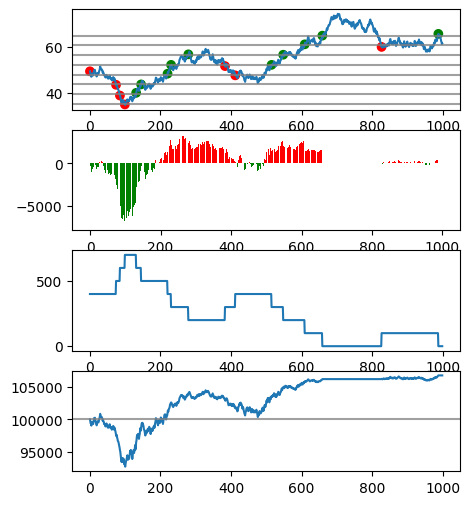

In [78]:
fig, axes = plt.subplots(4, 1, figsize=(5, 6))

axes[0].plot(x)
for i in strategy._grids:
    axes[0].axhline(i, color='gray', alpha=0.75)
axes[0].scatter(dates, prices, marker='o', color=['red' if op == 'buy' else 'green' for op in sides])


axes[1].bar(range(1000), profits, color=['red' if p >0 else 'green' for p in profits])
axes[2].plot(range(1000), holdings, color='C0')
axes[3].plot(captials)
axes[3].axhline(100000, color='gray', alpha=0.75)
# axes[3].plot(balances)

plt.show()

In [55]:
# show candle stick 
import pyecharts.options as opts
from pyecharts.charts import Candlestick
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
# # 配置对应的环境类型
# CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
# CurrentConfig.ONLINE_HOST='https://assets.pyecharts.org/assets/'
 
from pyecharts.globals import ThemeType

# x_data = ["2017-10-24", "2017-10-25", "2017-10-26", "2017-10-27"]
# y_data = [[20, 30, 10, 35], [40, 35, 30, 55], [33, 38, 33, 40], [40, 40, 32, 42]]

y_data = np.array(df[['open', 'close', 'low', 'high']]).tolist()
x_data = df.index.strftime("%Y-%m-%d %H:%M").values.tolist()

x_data = x_data[:100]
y_data = y_data[:100]


candle_stick = Candlestick(init_opts=opts.InitOpts(width="1000px", height="600px", theme=ThemeType.DARK))
candle_stick.add_xaxis(xaxis_data=x_data)
candle_stick.add_yaxis(series_name="kline", y_axis=y_data)
candle_stick.set_series_opts()
# candle_stick.set_global_opts(
#     yaxis_opts=opts.AxisOpts(
#         splitline_opts=opts.SplitLineOpts(
#             is_show=True, linestyle_opts=opts.LineStyleOpts(width=1)
#         )
#     )
# )
# candle_stick.load_javascript()

candle_stick.render_notebook()
